In [ ]:
#| default_exp sampler.direct

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
from qsample.sampler.base import Sampler, err_probs_tomatrix
import numpy as np

In [ ]:
#| export
class DirectSampler(Sampler):
    
    def __init__(self, protocol, simulator, err_model=None, err_probs=None):
        super().__init__(protocol, simulator, err_probs=err_probs, err_model=err_model)
        self.err_probs = err_probs_tomatrix(err_probs, self.err_model.groups)
    
    def stats(self, tree_idx=None):
        if tree_idx:
            p_L = self.trees[tree_idx].root_leaf_rate
            v_L = self.trees[tree_idx].root_leaf_variance
        else:
            p_L, v_L = [], []
            for tree in self.trees.values():
                p_L.append(tree.root_leaf_rate)
                v_L.append(tree.root_leaf_variance)
        return p_L, np.sqrt(v_L)
    
    def optimize(self, tree_node, circuit, grp_probs):
        locgrps = self.protocol_groups[circuit.id]
        flocs = self.err_model.choose_p(locgrps,grp_probs)
        subset = tuple(len(locs) for locs in flocs.values())
        return {'subset': subset, 'flocs': flocs}

In [ ]:
#| slow
from qsample.examples import ghz3
from qsample.noise import E1, E2
from qsample.sim.stabilizer import StabilizerSimulator as CHP
from qsample.callbacks import *

from ipywidgets import interact
import ipywidgets as widgets

p_phy=1.00E-03:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=5.62E-03:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=3.16E-02:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=1.78E-01:   0%|          | 0/1000 [00:00<?, ?it/s]

p_phy=1.00E+00:   0%|          | 0/1000 [00:00<?, ?it/s]

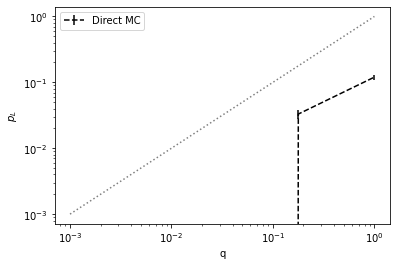

In [ ]:
#| slow

e = E1

sample_range = np.logspace(-3,0,5)

err_probs = {
    # "q1": 0,
    "q": sample_range
}

sam = DirectSampler(ghz3, CHP, err_probs=err_probs, err_model=e)

sam.run(1000, callbacks=[PlotStats()])

In [ ]:
#| slow

e = E2

sample_range = np.logspace(-3,0,5)

err_probs = {
    "q2": sample_range,
    "q1": 0.01
}

sam = DirectSampler(ghz3, CHP, err_probs=err_probs, err_model=e)

sam.run(1000, callbacks=[PlotStats()])

In [ ]:
#| slow

def get_tree(i):
    print("p_phy=", list(sam.trees.keys())[i])
    return (list(sam.trees.values())[i]).draw()
interact(get_tree, i=widgets.IntSlider(min=0, max=len(sam.trees)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='i', max=0), Output()), _dom_classes=('widget-interact',)…

In [ ]:
#| slow
sam.save('./test')

In [ ]:
#| slow
sam2 = Sampler.load('./test')
sam2.run(100)

p_phy=1.00E-01:   0%|          | 0/100 [00:00<?, ?it/s]